In [1]:
import tensorflow as tf
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
# 检查 TensorFlow 版本
print("TensorFlow version:", tf.__version__)

# 列出所有可用的物理设备
print("Physical devices:", tf.config.list_physical_devices())

# 检查是否有可用的 GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Num GPUs Available: ", len(gpus))
else:
    print("No GPU found. TensorFlow is using CPU.")

TensorFlow version: 2.6.0
Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]
Num GPUs Available:  4


In [2]:
## import package
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, mean_squared_error
import pandas as pd

### Build up basic model


In [3]:
def create_model(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Hidden Layers
    filter_sizes = [40, 20, 10, 20, 10, 30, 18, 18]
    kernel_sizes = [11, 1, 11, 1, 1, 11, 1, 3]
    x = inputs
    for filters, kernel_size in zip(filter_sizes, kernel_sizes):
        x = tf.keras.layers.Conv1D(filters, kernel_size, activation='relu', padding='same')(x)

    # Max Pooling Layer
    x = tf.keras.layers.MaxPooling1D(3)(x)

    # Flatten Layer
    x = tf.keras.layers.Flatten()(x)

    # Classification Layer
    classification_output = tf.keras.layers.Dense(input_shape[0], activation='sigmoid')(x)
    classification_output = tf.keras.layers.Reshape((input_shape[0],1))(classification_output)
    
    # Regression Layer
    reg_output = tf.keras.layers.Dense(5, name='reg_output')(x)


    # Model
    model = tf.keras.models.Model(inputs=inputs, outputs=[classification_output, reg_output])

    return model



In [4]:

input_shape = (100,1)  # 示例输入形状
num_classes = 2  # 假设有个类别

# 创建模型
model = create_model(input_shape, num_classes)
print(model.output_shape)


[(None, 100, 1), (None, 5)]


2025-01-17 09:45:49.149033: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-17 09:45:50.541794: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46350 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:16:00.0, compute capability: 8.6
2025-01-17 09:45:50.542419: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46716 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:34:00.0, compute capability: 8.6
2025-01-17 09:45:50.542861: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device

## Train the model

In [5]:
def compile_model(model):
    # 使用Adam优化器，学习率为0.002
    optimizer = optimizers.Adam(learning_rate=0.002)
    
    # 为每个输出指定一个损失函数
    losses = {
        'reshape': 'binary_crossentropy',  # 二元分类任务使用交叉熵损失函数
        'reg_output': 'mean_squared_error'  # 回归任务使用均方误差损失函数
    }
    
    # 为每个输出指定一个评估指标
    metrics = {
        'reshape': 'accuracy',  # 二元分类任务使用准确率作为评估指标
        'reg_output': tf.keras.metrics.MeanSquaredError()  # 回归任务使用均方误差作为评估指标
    }
    
    # 编译模型
    model.compile(optimizer=optimizer, loss=losses, metrics=metrics)

In [6]:
import pandas as pd
import numpy as np

def load_data(filename):
    # 读取 Excel 文件中的所有工作表名称
    xls = pd.ExcelFile(filename)
    sheet_names = xls.sheet_names

    # 初始化用于存储所有工作表数据的列表
    X_data = []
    classification_Y_data = []
    regression_Y_data = []

    # 遍历每个工作表
    for sheet_name in sheet_names:
        df = pd.read_excel(xls, sheet_name=sheet_name)
        
        # 提取 X 列和 y_classification 列的数据
        X = df['X'].to_numpy()
        Y = df['y_classification'].to_numpy()
        
        # 提取 y_regression 列的数据，作为回归任务的目标
        reg_target = df['y_regression'].dropna().to_numpy()[:5]  # 只提取前5个非 NaN 值

        # 将数据添加到列表中
        X_data.append(X)
        classification_Y_data.append(Y)
        regression_Y_data.append(reg_target)
    
    # 转换为 NumPy 数组并重塑为 (num_samples, sequence_length, num_features)
    X_data = np.array(X_data)
    classification_Y_data = np.array(classification_Y_data)
    regression_Y_data = np.array(regression_Y_data).reshape(-1, 5)

    return X_data, classification_Y_data, regression_Y_data


"""
# 示例调用
filename = "test_data.xlsx"
X_train, y_train_classification, y_train_regression = load_data(filename)

print(f'X_train shape: {X_train.shape}')
print(f'y_train_classification shape: {y_train_classification.shape}')
print(f'y_train_regression shape: {y_train_regression.shape}')
"""

'\n# 示例调用\nfilename = "test_data.xlsx"\nX_train, y_train_classification, y_train_regression = load_data(filename)\n\nprint(f\'X_train shape: {X_train.shape}\')\nprint(f\'y_train_classification shape: {y_train_classification.shape}\')\nprint(f\'y_train_regression shape: {y_train_regression.shape}\')\n'

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
def train_classification_model(model, X_train, y_train_classification, y_train_regression, X_val, y_val_classification, y_val_regression):
    # 使用所有数据同时进行训练，batch_size设置为训练集大小
    batch_size = len(X_train)
    # 训练模型，训练4000个epoch

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    history = model.fit(X_train, [y_train_classification, y_train_regression], 
                        epochs=4000, 
                        batch_size=batch_size, 
                        validation_data=(X_val, [y_val_classification, y_val_regression]),
                        callbacks=[early_stopping])
                       
                        
    return history

In [8]:
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score


def evaluate_model(model, X_val, y_val_classification, y_val_regression):
    # 预测验证集
    y_pred_classification, y_pred_regression = model.predict(X_val)
    print(f'y_pred_classification shape: {y_pred_classification.shape}')
    print(f'y_pred_regression shape: {y_pred_regression.shape}')
    
    # 将分类预测结果转换为整数标签
    y_pred_classes = (y_pred_classification > 0.5).astype(int)
    
    # 打印调试信息
    print("Debugging Information:")
    print(f'y_val_classification shape: {y_val_classification.shape}, y_val_classification dtype: {y_val_classification.dtype}')
    print(f'y_pred_classes shape: {y_pred_classes.shape}, y_pred_classes dtype: {y_pred_classes.dtype}')
    
    # 确保 y_val_classification 和 y_pred_classes 的形状一致
    y_val_classes = y_val_classification
    
    # 展开为一维数组
    y_val_classes_flat = y_val_classes.flatten()
    y_pred_classes_flat = y_pred_classes.flatten()
    
    # 打印分类报告
    print("Classification Report:")
    class_report = classification_report(y_val_classes_flat, y_pred_classes_flat, output_dict=True)
    print(classification_report(y_val_classes_flat, y_pred_classes_flat))
    
    # 将分类报告转换为 DataFrame 并写入 CSV 文件
    classification_df = pd.DataFrame(class_report).transpose()
    classification_df.to_csv('classification_report.csv', index=True)
    
    # 回归评估
    # 打印调试信息以检查形状
    print(f'y_val_regression shape: {y_val_regression.shape}')
    print(f'y_pred_regression shape: {y_pred_regression.shape}')
    
    # 确保 y_val_regression 和 y_pred_regression 的形状一致
    y_val_regression_flat = y_val_regression.flatten()
    y_pred_regression_flat = y_pred_regression.flatten()
    
    # 再次打印形状以确保一致性
    print(f'y_val_regression_flat shape: {y_val_regression_flat.shape}')
    print(f'y_pred_regression_flat shape: {y_pred_regression_flat.shape}')
    
    # 计算回归评估指标
    mse = mean_squared_error(y_val_regression_flat, y_pred_regression_flat)
    mae = mean_absolute_error(y_val_regression_flat, y_pred_regression_flat)
    r2 = r2_score(y_val_regression_flat, y_pred_regression_flat)
    
    print("Regression Evaluation:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R^2 Score: {r2}")
    
    # 将回归评估结果写入 CSV 文件
    regression_report = {
        'Metric': ['Mean Squared Error (MSE)', 'Mean Absolute Error (MAE)', 'R^2 Score'],
        'Value': [mse, mae, r2]
    }
    regression_df = pd.DataFrame(regression_report)
    regression_df.to_csv('regression_report.csv', index=False)


"""
def get_regression_values_for_class1(model, X_val,center, y_val_regression):
    # 得到预测值
    y_pred_classification, y_pred_regression = model.predict(X_val)
    
    final_output = []
    final_validation = []

    # 将分类预测结果转换为整数标签
    y_pred_classes = (y_pred_classification > 0.5).astype(int)
    
    for i in range(len(y_pred_classes)):

        # 获取分类输出中值为1的索引
        indices = np.where(y_pred_classes[i] == 1)[0]
        
        # 对每个分类输出值为1的索引,计算它与所有中心的距离
        distances = np.abs(indices.reshape(-1, 1) - np.array(center).reshape(1, -1))

        # 找到最近的中心
        closest_center_indices = np.argmin(distances, axis=1)

        # 为每个分类输出值为1的索引返回对应的回归值
        final_output.append(y_pred_regression[i, closest_center_indices])
        final_validation.append(y_val_regression[i, closest_center_indices])

    return np.array(final_output), np.array(final_validation)
"""

def get_regression_values_for_class1(model, X_val, center, y_val_regression):
    # 得到预测值
    y_pred_classification, y_pred_regression = model.predict(X_val)
    
    final_output = []
    final_validation = []

    final_output_for_plot = []
    final_validation_for_plot = []

    class1_indices_per_sample = []  # 新增的列表来存储每个样本中被分类为 class 1 的索引

    # 将分类预测结果转换为整数标签
    y_pred_classes = (y_pred_classification > 0.5).astype(int)
    
    for i in range(len(y_pred_classes)):
        # 获取分类输出中值为1的索引
        indices = np.where(y_pred_classes[i] == 1)[0]
        
        # 记录这些索引
        class1_indices_per_sample.append(indices)

        # 对每个分类输出值为1的索引，计算它与所有中心的距离
        distances = np.abs(indices.reshape(-1, 1) - np.array(center).reshape(1, -1))

        # 找到最近的中心
        closest_center_indices = np.argmin(distances, axis=1)

        # 为每个分类输出值为1的索引返回对应的回归值
        final_output.extend(y_pred_regression[i][closest_center_indices].tolist())
        final_validation.extend(y_val_regression[i][closest_center_indices].tolist())

        # 为plot存数据
        final_output_for_plot.append(y_pred_regression[i, closest_center_indices])
        final_validation_for_plot.append(y_val_regression[i, closest_center_indices])

    return np.array(final_output), np.array(final_validation), np.array(final_output_for_plot, dtype=object), np.array(final_validation_for_plot, dtype=object), class1_indices_per_sample

In [9]:
Training_areas = [[0,1,5,50,95,100],[0,1,5,50,95,100,200],[0,1,5,50,95,200,300],[0,1,5,50,95,300,400],[0,1,5,50,95,400,500],[0,1,5,50,95,500,600],[0,1,5,50,95,600,700],[0,1,5,50,95,700,800],[0,1,5,50,95,800,900],[0,1,5,50,95,900,1000]]
Training_areas_new = []

# 更改训练数据的分位数区间
for areas in Training_areas:
    max_area = areas[-1]  # 获取当前区间的最大值
    # 创建新的四分位数区间，并四舍五入到最接近的整数
    new_areas = [round(val) for val in [0, 0.2*max_area, 0.5*max_area, 0.8*max_area, max_area]]
    Training_areas_new.append(new_areas)

print(Training_areas_new)

[[0, 20, 50, 80, 100], [0, 40, 100, 160, 200], [0, 60, 150, 240, 300], [0, 80, 200, 320, 400], [0, 100, 250, 400, 500], [0, 120, 300, 480, 600], [0, 140, 350, 560, 700], [0, 160, 400, 640, 800], [0, 180, 450, 720, 900], [0, 200, 500, 800, 1000]]


In [10]:
from tensorflow.keras import backend as K
import Generate_comparision


centers = [20, 30, 40, 60, 70]
sigma = 8
noise_level = 1/300 
Training_areas = [0, 1,12,14,120, 300, 480, 600]
Testing_areas = [0, 1,7, 230, 360, 590]



absolute_list = []
relative_list = []

K.clear_session()
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
# 设置输入形状和类别数量
    input_shape = (100,1)  # 示例输入形状
    num_classes = 2  # 假设有2个类别

    # 创建模型
    model = create_model(input_shape, num_classes)
    model.summary()

        # 编译模型
    compile_model(model)

# 加载和预处理数据
# 从 train_data.xlsx 中加载数据
X_train, y_train_classification, y_train_regression = Generate_comparision.generate_data(centers, Training_areas, sigma, noise_level, x_size=100)
# 划分训练集和验证集
X_train, X_val, y_train_classification, y_val_classification, y_train_regression, y_val_regression = train_test_split(X_train, y_train_classification, y_train_regression, test_size=0.2)


# 从 test_data.xlsx 中加载数据（如果有相同的结构）
X_test, y_test_classification, y_test_regression = Generate_comparision.generate_data(centers, Testing_areas, sigma, noise_level, x_size=100)

# 训练模型
history = train_classification_model(model, X_train, y_train_classification, y_train_regression, X_val, y_val_classification, y_val_regression)
# 保存模型
model.save('my_model.h5')
# 评估模型
evaluate_model(model, X_test, y_test_classification, y_test_regression)

#得到最终的回归值
centers  = [20,30,40,60,70]
final,val,pred_plot,test_plot,indices_for_class1  = get_regression_values_for_class1(model, X_test,centers,y_test_regression)

y_pred_classification, y_pred_regression = model.predict(X_test)
y_pred_classes = (y_pred_classification > 0.5).astype(int)
y_val_classes_flat = y_test_classification.flatten()
y_pred_classes_flat = y_pred_classes.flatten() 
y_pred_regression_flat = y_pred_regression.flatten()
y_val_regression_flat = y_test_regression.flatten()

container_all = []
container_relative = []
for i in range (len(y_pred_regression_flat)):
        error = y_pred_regression_flat[i] -  y_val_regression_flat[i]
        container_all.append(error)
        if y_val_regression_flat[i] == 0:
            relative_error = error/1
        else:
            relative_error = error/y_val_regression_flat[i]
        container_relative.append(relative_error)
    
absolute_list.append(container_all)
relative_list.append(container_relative)





X_data shape: (1296, 100)
y_classification shape: (1296, 100)
y_regression shape: (1296, 4)
y_regression [0 0 0 0]
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 100, 40)      480         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)              

2025-01-17 09:45:55.817441: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_1156"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 26214
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Au

Epoch 1/4000
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1


2025-01-17 09:46:00.627060: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2025-01-17 09:46:01.305063: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2025-01-17 09:46:02.006887: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2025-01-17 09:46:02.469637: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2025-01-17 09:46:04.113283: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - ETA: 0s - loss: 86800.1016 - reshape_loss: 0.8034 - reg_output_loss: 86799.3047 - reshape_accuracy: 0.4608 - reg_output_mean_squared_error: 86799.3047

2025-01-17 09:46:04.915944: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_8872"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = AutoS

1/1 [==============================] - 11s 11s/step - loss: 86800.1016 - reshape_loss: 0.8034 - reg_output_loss: 86799.3047 - reshape_accuracy: 0.4608 - reg_output_mean_squared_error: 86799.3047 - val_loss: 86646.8984 - val_reshape_loss: 0.7010 - val_reg_output_loss: 86646.1953 - val_reshape_accuracy: 0.5917 - val_reg_output_mean_squared_error: 86646.1953
Epoch 2/4000
1/1 [==============================] - 0s 151ms/step - loss: 86467.8125 - reshape_loss: 0.7008 - reg_output_loss: 86467.1094 - reshape_accuracy: 0.5917 - reg_output_mean_squared_error: 86467.1094 - val_loss: 86094.6094 - val_reshape_loss: 0.5783 - val_reg_output_loss: 86094.0391 - val_reshape_accuracy: 0.7083 - val_reg_output_mean_squared_error: 86094.0391
Epoch 3/4000
1/1 [==============================] - 0s 148ms/step - loss: 85915.7422 - reshape_loss: 0.5778 - reg_output_loss: 85915.1719 - reshape_accuracy: 0.7088 - reg_output_mean_squared_error: 85915.1719 - val_loss: 85162.1953 - val_reshape_loss: 0.4332 - val_reg_o

2025-01-17 09:47:54.541174: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_321650"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Aut

y_pred_classification shape: (7776, 100, 1)
y_pred_regression shape: (7776, 5)
Debugging Information:
y_val_classification shape: (7776, 100), y_val_classification dtype: float64
y_pred_classes shape: (7776, 100, 1), y_pred_classes dtype: int64
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    745200
         1.0       0.94      0.95      0.95     32400

    accuracy                           1.00    777600
   macro avg       0.97      0.97      0.97    777600
weighted avg       1.00      1.00      1.00    777600

y_val_regression shape: (7776, 5)
y_pred_regression shape: (7776, 5)
y_val_regression_flat shape: (38880,)
y_pred_regression_flat shape: (38880,)
Regression Evaluation:
Mean Squared Error (MSE): 0.44466664957300417
Mean Absolute Error (MAE): 0.48143231913278745
R^2 Score: 0.9999909689739649


2025-01-17 09:47:58.059748: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_322951"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 32
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to DATA to shard this dataset. You can do this by creating a new `tf.data.Options()` object then setting `options.experimental_distribute.auto_shard_policy = Aut

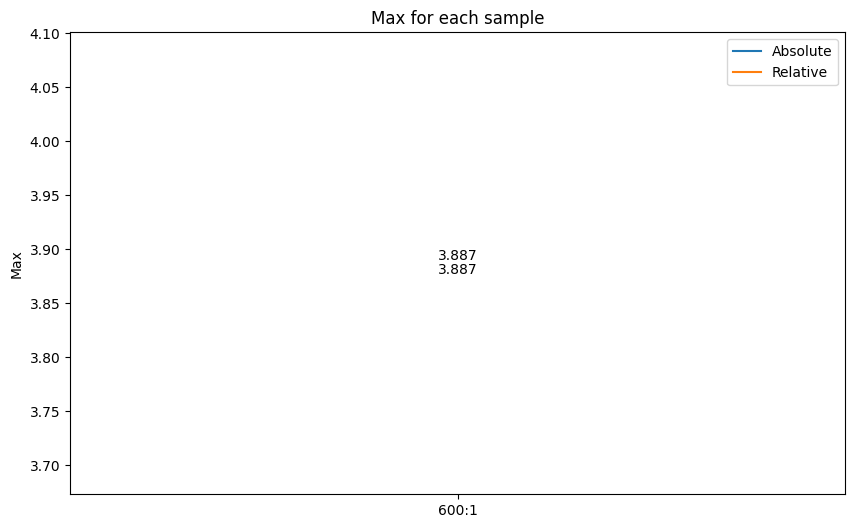

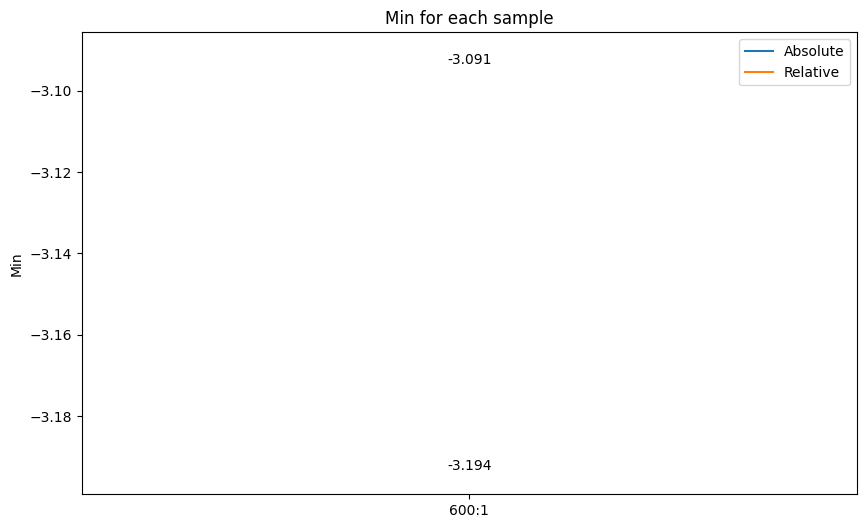

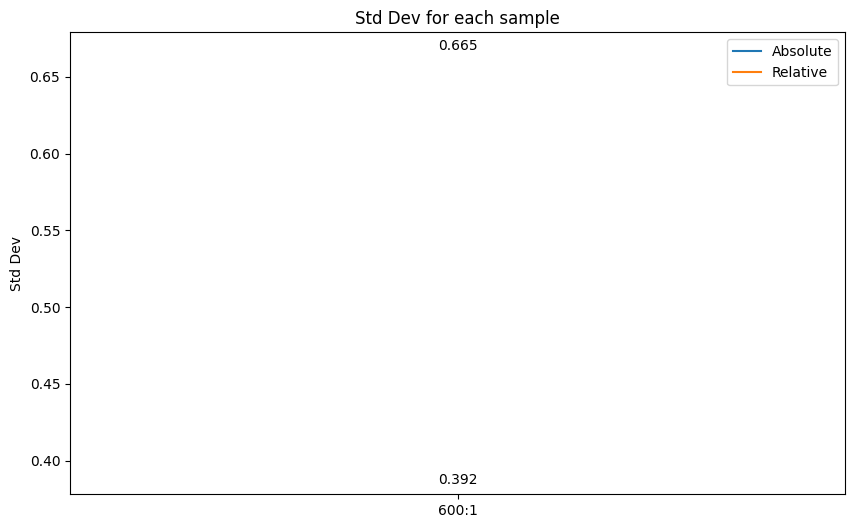

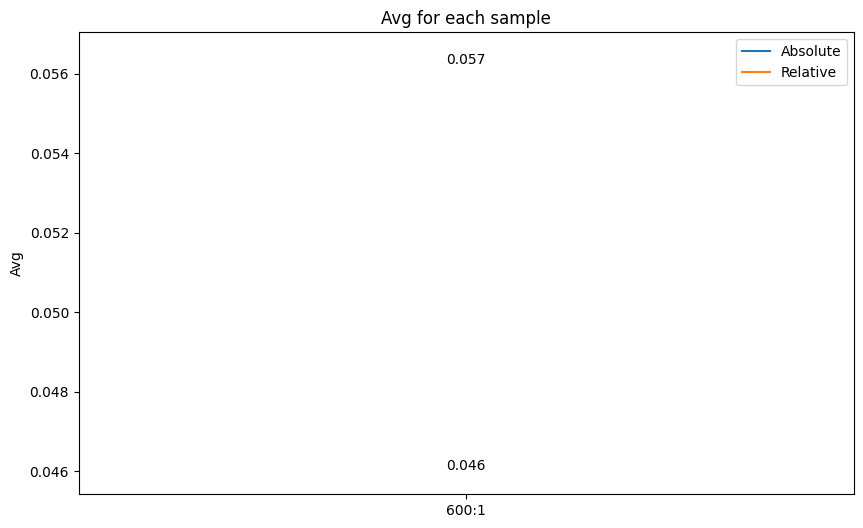

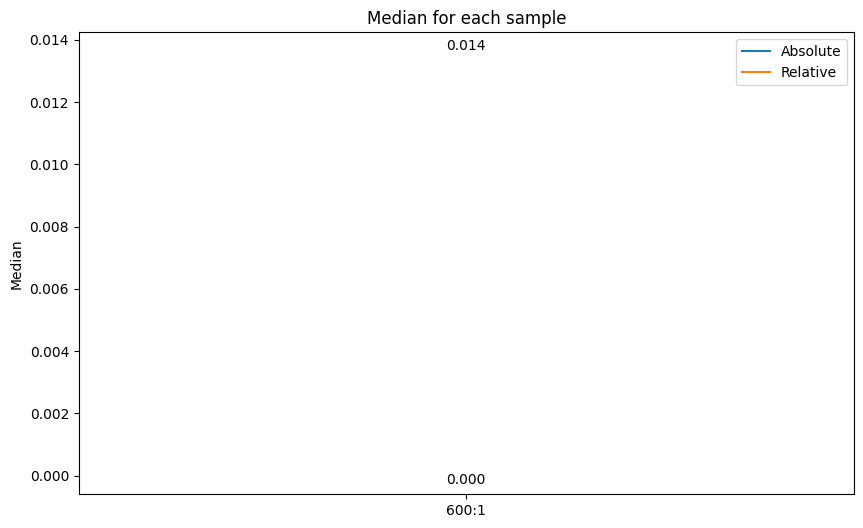

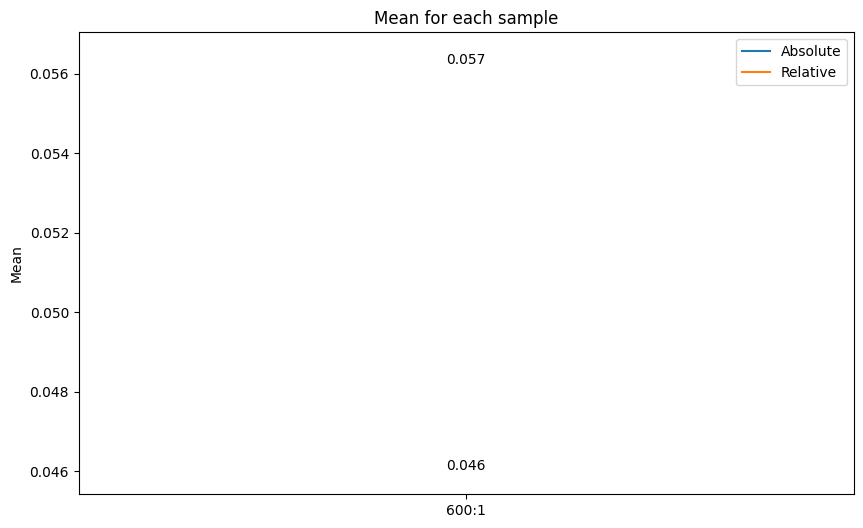

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 计算统计值
def calculate_stats(data_list):
    stats = []
    for data in data_list:
        max_val = np.max(data)
        min_val = np.min(data)
        std_dev = np.std(data)
        avg = np.mean(data)
        median = np.median(data)
        mean = np.mean(data)
        stats.append([max_val, min_val, std_dev, avg, median, mean])
    return np.array(stats)

# 计算绝对误差和相对误差的统计值
stats_absolute = calculate_stats(absolute_list)
stats_relative = calculate_stats(relative_list)

# 定义统计值的标签
labels = ['Max', 'Min', 'Std Dev', 'Avg', 'Median', 'Mean']

# 定义x轴的标签
x = ['600:1']

# 对于每一个统计值，绘制一条折线图
for i in range(len(labels)):
    plt.figure(figsize=(10, 6))
    plt.plot(stats_absolute[:, i], label='Absolute')
    plt.plot(stats_relative[:, i], label='Relative')
    
    # 在每个数据点上添加标签
    for j in range(len(x)):
        plt.text(j, stats_absolute[j, i], f'{stats_absolute[j, i]:.3f}', ha='center', va='bottom')
        plt.text(j, stats_relative[j, i], f'{stats_relative[j, i]:.3f}', ha='center', va='top')
    
    plt.xticks(range(len(x)), x)  # 设置x轴的标签
    plt.ylabel(labels[i])
    plt.title(f'{labels[i]} for each sample')
    plt.legend()
    plt.show()

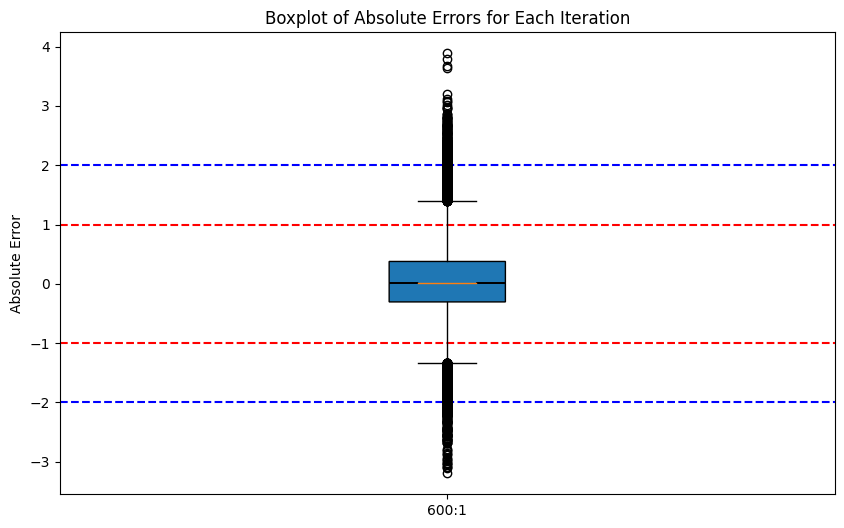

In [20]:
import matplotlib.pyplot as plt
# 假设你的标签列表是这样的
x = ['600:1']
# 创建一个新的图形
plt.figure(figsize=(10, 6))
# 在-1, 1, 2, -2处添加水平线
plt.axhline(y=-1, color='r', linestyle='--')
plt.axhline(y=1, color='r', linestyle='--')
plt.axhline(y=2, color='b', linestyle='--')
plt.axhline(y=-2, color='b', linestyle='--')
# 创建箱线图
# 注意：你需要将你的数据转换为列表并传入到boxplot函数中
plt.boxplot(absolute_list, vert=True, notch=True, patch_artist=True)

# 设置x轴的标签为你的x列表
plt.xticks(range(1, len(x) + 1), x)

# 设置标题和标签
plt.title('Boxplot of Absolute Errors for Each Iteration')
plt.ylabel('Absolute Error')

# 显示图形
plt.show()

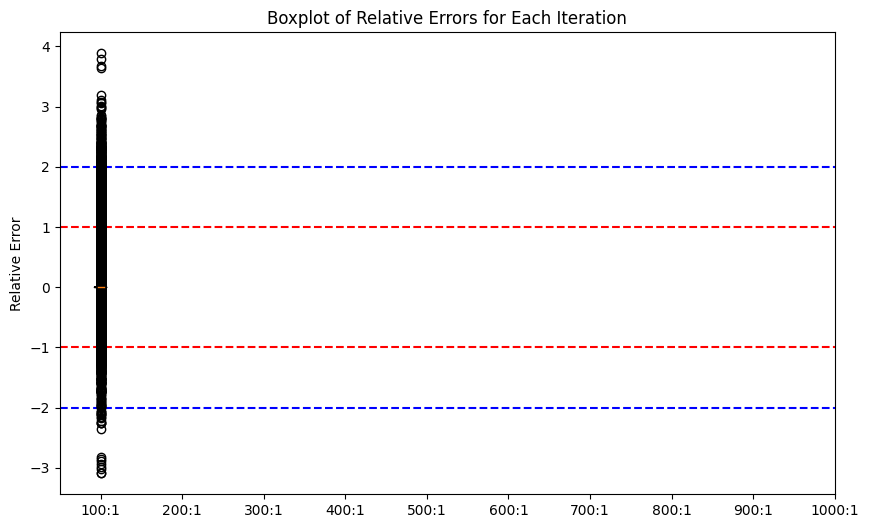

In [13]:
import matplotlib.pyplot as plt
# 假设你的标签列表是这样的
x = ['100:1', '200:1', '300:1', '400:1', '500:1', '600:1', '700:1', '800:1', '900:1', '1000:1']
# 创建一个新的图形
plt.figure(figsize=(10, 6))
# 在-1, 1, 2, -2处添加水平线
plt.axhline(y=-1, color='r', linestyle='--')
plt.axhline(y=1, color='r', linestyle='--')
plt.axhline(y=2, color='b', linestyle='--')
plt.axhline(y=-2, color='b', linestyle='--')
# 创建箱线图
# 注意：你需要将你的数据转换为列表并传入到boxplot函数中
plt.boxplot(relative_list, vert=True, notch=True, patch_artist=True)
#plt.ylim(-0.25, 0.25)

# 设置x轴的标签为你的x列表
plt.xticks(range(1, len(x) + 1), x)

# 设置标题和标签
plt.title('Boxplot of Relative Errors for Each Iteration')
plt.ylabel('Relative Error')

# 显示图形
plt.show()

In [14]:
"""
import numpy as np
import itertools

# 找到 '500:1' 在 x 中的索引
index = x.index('500:1')

# 获取相应的数据
data = absolute_list[index]

# 计算四分位数和IQR
q1 = np.percentile(data, 25)
q3 = np.percentile(data, 75)
iqr = q3 - q1

# 计算上下界
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr


# 找到异常值及其索引
outliers = [(i, val) for i, val in enumerate(data) if val < lower_bound or val > upper_bound]
outlier_indices = [outlier[0] for outlier in outliers]
outlier_val = [outlier[1] for outlier in outliers]
areas = [0,2,160,300,480]
centers = [20, 30, 40, 60, 70]
area_combinations = list(itertools.product(areas, repeat=len(centers)))
"""

"\nimport numpy as np\nimport itertools\n\n# 找到 '500:1' 在 x 中的索引\nindex = x.index('500:1')\n\n# 获取相应的数据\ndata = absolute_list[index]\n\n# 计算四分位数和IQR\nq1 = np.percentile(data, 25)\nq3 = np.percentile(data, 75)\niqr = q3 - q1\n\n# 计算上下界\nlower_bound = q1 - 1.5 * iqr\nupper_bound = q3 + 1.5 * iqr\n\n\n# 找到异常值及其索引\noutliers = [(i, val) for i, val in enumerate(data) if val < lower_bound or val > upper_bound]\noutlier_indices = [outlier[0] for outlier in outliers]\noutlier_val = [outlier[1] for outlier in outliers]\nareas = [0,2,160,300,480]\ncenters = [20, 30, 40, 60, 70]\narea_combinations = list(itertools.product(areas, repeat=len(centers)))\n"

In [15]:
"""
# 初始化一个空的字典来存储分组的索引
grouped_indices = {}

# 对每个异常值的索引进行模除5并分组
for index in outlier_indices:
    remainder = index // 5
    if remainder not in grouped_indices:
        grouped_indices[remainder] = [index]
    else:
        grouped_indices[remainder].append(index)

# 输出分组的索引
for remainder, indices in grouped_indices.items():
    #print(f'Remainder: {remainder}, Indices: {indices}')

    # 根据模除的结果在area_combinations中找到对应的组合
    area_combination = area_combinations[remainder]
    #print(f'Corresponding area combination: {area_combination}')

    for index in indices:
        corresponding_number = area_combination[index % 5]
        print(f'Index: {index}, Corresponding number: {corresponding_number}')
"""

"\n# 初始化一个空的字典来存储分组的索引\ngrouped_indices = {}\n\n# 对每个异常值的索引进行模除5并分组\nfor index in outlier_indices:\n    remainder = index // 5\n    if remainder not in grouped_indices:\n        grouped_indices[remainder] = [index]\n    else:\n        grouped_indices[remainder].append(index)\n\n# 输出分组的索引\nfor remainder, indices in grouped_indices.items():\n    #print(f'Remainder: {remainder}, Indices: {indices}')\n\n    # 根据模除的结果在area_combinations中找到对应的组合\n    area_combination = area_combinations[remainder]\n    #print(f'Corresponding area combination: {area_combination}')\n\n    for index in indices:\n        corresponding_number = area_combination[index % 5]\n        print(f'Index: {index}, Corresponding number: {corresponding_number}')\n"

In [16]:
"""
import pandas as pd

# 初始化一个空的 DataFrame
df = pd.DataFrame(columns=['Combination', 'Corresponding Number'])

# 获取异常值
outlier_val = [outlier[1] for outlier in outliers]

# 遍历每个组
for remainder, indices in grouped_indices.items():
    # 根据模除的结果找到对应的组合
    area_combination = area_combinations[remainder]

    if len(indices) == 1:
        for i, index in enumerate(indices):
            # 找到对应的数字
            corresponding_number = area_combination[index % 5]

            # 创建一个新的组合字符串，只在索引对应的数字后面添加括号和异常值
            area_combination_str = "(" + ", ".join([f"{num} ({outlier_val[i]})" if idx == index % 5 else str(num) for idx, num in enumerate(area_combination)]) + ")"

            # 创建一个新的 DataFrame 并将其添加到原始 DataFrame 中
            new_df = pd.DataFrame({
                'Combination': [area_combination_str],
                'Corresponding Number': [corresponding_number],
            })
            df = pd.concat([df, new_df], ignore_index=True)
    else:
        # 对多个值的情况进行处理
        area_combination_str = [str(num) for num in area_combination]
        for i, index in enumerate(indices):
            num_idx = index % 5
            if '(' in area_combination_str[num_idx]:
                # 如果已经有异常值，追加
                area_combination_str[num_idx] = area_combination_str[num_idx].replace(')', f", {outlier_val[i]})")
            else:
                area_combination_str[num_idx] = f"{area_combination[num_idx]} ({outlier_val[i]})"
        
        area_combination_str = "(" + ", ".join(area_combination_str) + ")"
        corresponding_numbers = [area_combination[index % 5] for index in indices]
        
        new_df = pd.DataFrame({
            'Combination': [area_combination_str],
            'Corresponding Number': [corresponding_numbers],
        })
        df = pd.concat([df, new_df], ignore_index=True)

# 打印 DataFrame
print(df)

# 将 DataFrame 保存到 CSV 文件
df.to_csv('outliers.csv', index=False)
"""

'\nimport pandas as pd\n\n# 初始化一个空的 DataFrame\ndf = pd.DataFrame(columns=[\'Combination\', \'Corresponding Number\'])\n\n# 获取异常值\noutlier_val = [outlier[1] for outlier in outliers]\n\n# 遍历每个组\nfor remainder, indices in grouped_indices.items():\n    # 根据模除的结果找到对应的组合\n    area_combination = area_combinations[remainder]\n\n    if len(indices) == 1:\n        for i, index in enumerate(indices):\n            # 找到对应的数字\n            corresponding_number = area_combination[index % 5]\n\n            # 创建一个新的组合字符串，只在索引对应的数字后面添加括号和异常值\n            area_combination_str = "(" + ", ".join([f"{num} ({outlier_val[i]})" if idx == index % 5 else str(num) for idx, num in enumerate(area_combination)]) + ")"\n\n            # 创建一个新的 DataFrame 并将其添加到原始 DataFrame 中\n            new_df = pd.DataFrame({\n                \'Combination\': [area_combination_str],\n                \'Corresponding Number\': [corresponding_number],\n            })\n            df = pd.concat([df, new_df], ignore_index=True)\n    else:

In [17]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train_classification shape: {y_train_classification.shape}')
print(f'y_train_regression shape: {y_train_regression.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val_classification shape: {y_val_classification.shape}')
print(f'y_val_regression shape: {y_val_regression.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test_classification shape: {y_test_classification.shape}')
print(f'y_test_regression shape: {y_test_regression.shape}')

X_train shape: (26214, 100)
y_train_classification shape: (26214, 100)
y_train_regression shape: (26214, 5)
X_val shape: (6554, 100)
y_val_classification shape: (6554, 100)
y_val_regression shape: (6554, 5)
X_test shape: (7776, 100)
y_test_classification shape: (7776, 100)
y_test_regression shape: (7776, 5)


In [18]:
"""
import numpy as np
import itertools
import pandas as pd


def analyze_sample(sample_index, absolute_list, x, areas, centers):
    # 找到样本在 x 中的索引
    sample_label = x[sample_index - 1]
    print(f'Analyzing sample: {sample_label}')

    # 获取相应的数据
    data = absolute_list[sample_index - 1]

    # 计算四分位数和IQR
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1

    # 计算上下界
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    print(f'Lower Bound: {lower_bound}, Upper Bound: {upper_bound}')

    # 找到异常值及其索引
    outliers = [(i, val) for i, val in enumerate(data) if val < lower_bound or val > upper_bound]
    outlier_indices = [outlier[0] for outlier in outliers]
    outlier_vals = [outlier[1] for outlier in outliers]

    # 创建一个字典来确保索引和异常值匹配
    outlier_dict = dict(zip(outlier_indices, outlier_vals))

    # 生成所有可能的组合
    area_combinations = list(itertools.product(areas[sample_index - 1], repeat=len(centers)))

    #计算所有组合中0的个数
    zero_count = 0
    for area_combination in area_combinations:
        zero_count += area_combination.count(0)

    # 初始化一个空的字典来存储分组的索引
    grouped_indices = {}

    # 对每个异常值的索引进行模除5并分组
    for index in outlier_indices:
        remainder = index // 5
        if remainder not in grouped_indices:
            grouped_indices[remainder] = [index]
        else:
            grouped_indices[remainder].append(index)

    # 初始化一个空的 DataFrame
    df = pd.DataFrame(columns=['Combination', 'Corresponding Number'])

    # 初始化 zero_count 总和计数器
    total_zero_outlier_count = 0

    # 遍历每个组
    for remainder, indices in grouped_indices.items():
        # 根据模除的结果找到对应的组合
        area_combination = area_combinations[remainder]
        zero_outlier_count = 0  # 初始化当前组的0的异常值计数器

        if len(indices) == 1:
            for index in indices:
                # 找到对应的数字
                corresponding_number = area_combination[index % 5]

                # 通过 outlier_dict 字典获得异常值
                val = outlier_dict[index]

                # 检查是否是0且为outlier
                if corresponding_number == 0:
                    zero_outlier_count += 1

                # 创建一个新的组合字符串，只在索引对应的数字后面添加括号和异常值
                area_combination_str = "(" + ", ".join([f"{num} ({val})" if idx == index % 5 else str(num) for idx, num in enumerate(area_combination)]) + ")"

                # 创建一个新的 DataFrame 并将其添加到原始 DataFrame 中
                new_df = pd.DataFrame({
                    'Combination': [area_combination_str],
                    'Corresponding Number': [corresponding_number]
                })
                df = pd.concat([df, new_df], ignore_index=True)
        else:
            # 对多个值的情况进行处理
            area_combination_str = [str(num) for num in area_combination]
            for index in indices:
                num_idx = index % 5
                val = outlier_dict[index]
                if '(' in area_combination_str[num_idx]:
                    # 如果已经有异常值，追加
                    area_combination_str[num_idx] = area_combination_str[num_idx].replace(')', f", {val})")
                else:
                    area_combination_str[num_idx] = f"{area_combination[num_idx]} ({val})"
                
                # 检查是否是0且为outlier
                if area_combination[num_idx] == 0:
                    zero_outlier_count += 1
            
            area_combination_str = "(" + ", ".join(area_combination_str) + ")"
            corresponding_numbers = [area_combination[index % 5] for index in indices]
            
            new_df = pd.DataFrame({
                'Combination': [area_combination_str],
                'Corresponding Number': [corresponding_numbers]
            })
            df = pd.concat([df, new_df], ignore_index=True)

        # 累加当前组的 zero_outlier_count 到 total_zero_outlier_count
        total_zero_outlier_count += zero_outlier_count

    # 打印 DataFrame
    print(df)
    
    # 打印 zero_outlier_count 总和
    print(f"Total count of 0 as outliers: {total_zero_outlier_count}")
    print(f"Total count of 0 in all combinations: {zero_count}")
    
    # 计算0作为outlier的百分比
    if zero_count > 0:
        zero_outlier_percentage = (total_zero_outlier_count / zero_count) * 100
        print(f"Percentage of 0 as outliers: {zero_outlier_percentage:.2f}%")
    else:
        print("No 0 values found in the data.")
    
    # 将 DataFrame 保存到 CSV 文件
    df.to_csv(f'outliers_{sample_label}.csv', index=False)
# 示例调用

x = ['100:1', '200:1', '300:1', '400:1', '500:1', '600:1', '700:1', '800:1', '900:1', '1000:1']
Training_areas =[[0,1,2,4,20, 50, 80, 100], [0,1,4,6,40, 100, 160, 200], [0,1,6,8,60,150,240,300], [0, 1,8,10,80, 200, 320, 400], 
                 [0, 1,10,12,100, 250, 400, 500], [0, 1,12,14,120, 300, 480, 600], [0,1,14,16,140, 350, 560, 700], [0,1,16,18,160, 400, 640, 800],
                 [0,1,18,20,180, 450, 720, 900], [0,1,20,22,200, 500, 800, 1000]]
#Training_areas = [[0,1,20,50,80,100], [0,1,40,100,160,200], [0,1,60,150,240,300], [0,1,80,200,320,400], [0,1,100,250,400,500], [0,1,120,300,480,600], [0,1,140,350,560,700], [0,1,160,400,640,800], [0,1,180,450,720,900], [0,1,200,500,800,1000]]
#Testing_areas = [[0,2,30,60,100] ,[0,2,70,120,175],[0,2,80,170,280],[0,2,100,250,370],[0,2,160,300,480],[0,2,240,350,560],[0,2,255,400,600],[0,2,290,450,720],[0,2,340,500,800],[0,2,370,550,880]]
Testing_areas = [
    [0, 2, 25, 55, 105],
    [0, 3, 45, 110, 180],
    [0, 4, 75, 160, 275],
    [0, 5, 95, 260, 385],
    [0, 6, 150, 310, 490],
    [0, 7, 230, 360, 590],
    [0, 8, 250, 410, 610],
    [0, 9, 280, 460, 730],
    [0, 10, 330, 510, 810],
    [0, 12, 360, 550, 900]
]
centers = [20, 30, 40, 60, 70]

for i in range(1,11):
    analyze_sample(i, absolute_list, x, Testing_areas, centers)  # 查看第n个样本
"""

'\nimport numpy as np\nimport itertools\nimport pandas as pd\n\n\ndef analyze_sample(sample_index, absolute_list, x, areas, centers):\n    # 找到样本在 x 中的索引\n    sample_label = x[sample_index - 1]\n    print(f\'Analyzing sample: {sample_label}\')\n\n    # 获取相应的数据\n    data = absolute_list[sample_index - 1]\n\n    # 计算四分位数和IQR\n    q1 = np.percentile(data, 25)\n    q3 = np.percentile(data, 75)\n    iqr = q3 - q1\n\n    # 计算上下界\n    lower_bound = q1 - 1.5 * iqr\n    upper_bound = q3 + 1.5 * iqr\n\n    print(f\'Lower Bound: {lower_bound}, Upper Bound: {upper_bound}\')\n\n    # 找到异常值及其索引\n    outliers = [(i, val) for i, val in enumerate(data) if val < lower_bound or val > upper_bound]\n    outlier_indices = [outlier[0] for outlier in outliers]\n    outlier_vals = [outlier[1] for outlier in outliers]\n\n    # 创建一个字典来确保索引和异常值匹配\n    outlier_dict = dict(zip(outlier_indices, outlier_vals))\n\n    # 生成所有可能的组合\n    area_combinations = list(itertools.product(areas[sample_index - 1], repeat=len(cente